# Confidence-aware IBCF MultiEval Example

This notebook demonstrates a basic parameter sweep with LensKits `MultiEval` class.

## Setup

We first need to import our libraries.

In [281]:
import sys
sys.path.insert(0,'C:\\Users\\Jacob\\Documents\\GitHub\\lenskit_confidence')

In [282]:
#from lenskit.batch import MultiEval
#from lenskit.crossfold import partition_users, SampleN
#from lenskit.algorithms import user_knn #basic, als, item_knn, user_knn
#from lenskit.datasets import MovieLens
#from lenskit import topn, util #, metrics
from lenskit.metrics import predict
import pandas as pd
import matplotlib.pyplot as plt

from lenskit.batch_ca import MultiEval
from lenskit.algorithms_ca import item_knn_ca, item_knn_ca, Recommender
from lenskit.metrics.predict import rmse
from lenskit import datasets
from lenskit.datasets import MovieLens
from lenskit import crossfold as xf
from lenskit import topn, datasets, batch_ca # *not* batch 
from lenskit import topn, util #, metrics
from lenskit.crossfold import partition_users, SampleN, partition_rows
#import pandas as pd
#import logging

Progress bars are useful:

In [283]:
from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()

C:\Users\Jacob\anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


It takes a little while to run things, and can get kinda quiet in here. Let's set up logging so we can see the logging output in the notebook's message stream:

In [4]:
util.log_to_notebook()

[   INFO] lenskit.util.log notebook logging configured


Then set up the data access.

In [284]:
#mlsmall = MovieLens('../data/ml-latest-small')
mlsmall = MovieLens('../data/ml-1m')
#mlsmall = MovieLens('../data/ml-10m')
#mlsmall = MovieLens('../data/ml-20m')

## Experiment

We're going to run our evaluation and store its output in the `my-eval` directory, generating 20-item recommendation lists::

In [317]:
eval = MultiEval('my-eval', predict = True, recommend = 100, eval_n_jobs = 4)

We're going to use a 5-fold cross-validation setup.  We save the data into a list in memory so we have access to the test data later.  In a larger experiment, you might write the partitions to disk and pass the file names to `add_datasets`.

In [286]:
pairs = list(partition_users(mlsmall.ratings, 5, SampleN(5)))
#pairs = (partition_users(mlsmall.ratings, 5, SampleN(5)))
pairs

[   INFO] lenskit.crossfold partitioning 1000209 rows for 6040 users into 5 partitions
[   INFO] lenskit.crossfold fold 0: selecting test ratings
[   INFO] lenskit.crossfold fold 0: partitioning training data
[   INFO] lenskit.crossfold fold 1: selecting test ratings
[   INFO] lenskit.crossfold fold 1: partitioning training data
[   INFO] lenskit.crossfold fold 2: selecting test ratings
[   INFO] lenskit.crossfold fold 2: partitioning training data
[   INFO] lenskit.crossfold fold 3: selecting test ratings
[   INFO] lenskit.crossfold fold 3: partitioning training data
[   INFO] lenskit.crossfold fold 4: selecting test ratings
[   INFO] lenskit.crossfold fold 4: partitioning training data


[TTPair(train=         Unnamed: 0  user  item  rating  timestamp
 0                 1     1  1193     5.0  978300760
 1                 2     1   661     3.0  978302109
 2                 3     1   914     3.0  978301968
 3                 4     1  3408     4.0  978300275
 4                 5     1  2355     5.0  978824291
 ...             ...   ...   ...     ...        ...
 1000203     1000204  6040  1090     3.0  956715518
 1000204     1000205  6040  1091     1.0  956716541
 1000205     1000206  6040  1094     5.0  956704887
 1000206     1000207  6040   562     5.0  956704746
 1000208     1000209  6040  1097     4.0  956715569
 
 [994169 rows x 5 columns], test=         Unnamed: 0  user  item  rating  timestamp
 85               86     2  1259     5.0  978298841
 162             163     2  3451     4.0  978298924
 143             144     2  1955     4.0  978299200
 107             108     2  2028     4.0  978299773
 93               94     2   110     5.0  978298625
 ...             

In [318]:
eval.add_datasets(pairs, name = 'ML-Small')

In [319]:
nhbr_range = [10, 25, 50, 75] #, 75] # 100] #, 100] #, 200]

In [ ]:
#eval.add_algorithms([item_knn.ItemItem(nnbrs = f, aggregate = 'weighted-average') for f in nhbr_range], 
#                    attrs = ['nnbrs'], name = 'ItemKNN-Weighted')

#eval.add_algorithms([item_knn.ItemItem(nnbrs = f, aggregate = 'sum') for f in nhbr_range], 
#                    attrs = ['nnbrs'], name = 'ItemKNN-Sum')

In [320]:
# Done
eval.add_algorithms([item_knn_ca.ItemItemCA(nnbrs = f, aggregate = 'weighted-average',
                                           variance_estimator = 'standard-deviation-weighted-average') for f in nhbr_range], 
                    attrs = ['nnbrs'], name = 'ItemKNN-CA-Weighted') 

In [321]:
# DONE
eval.add_algorithms([item_knn_ca.ItemItemCA(nnbrs = f, aggregate = 'average', 
                                            variance_estimator = 'standard-deviation-average') for f in nhbr_range], 
                    attrs = ['nnbrs'], name = 'ItemKNN-CA-Average') 

In [322]:
# DONE
eval.add_algorithms([item_knn_ca.ItemItemCA(nnbrs = f, aggregate = 'average', 
                                            variance_estimator = 'standard-deviation-jackknife-average') for f in nhbr_range], 
                    attrs = ['nnbrs'], name = 'ItemKNN-CA-JK-Average') 

In [323]:
# DONE - worked, but performs very poorly - maybe use non-weighted approach
eval.add_algorithms([item_knn_ca.ItemItemCA(nnbrs = f, aggregate = 'weighted-average', 
                                            variance_estimator = 'standard-deviation-jackknife-weighted-average') for f in nhbr_range], 
                    attrs = ['nnbrs'], name = 'ItemKNN-CA-JK-Weighted') 

In [324]:
# DONE
eval.add_algorithms([item_knn_ca.ItemItemCA(nnbrs = f, aggregate = 'average', 
                                            variance_estimator = 'standard-deviation-bootstrap-average') for f in nhbr_range], 
                    attrs = ['nnbrs'], name = 'ItemKNN-CA-BS-Average') 

In [325]:
# doing now
eval.add_algorithms([item_knn_ca.ItemItemCA(nnbrs = f, aggregate = 'weighted-average', 
                                            variance_estimator = 'standard-deviation-bootstrap-weighted-average') for f in nhbr_range], 
                    attrs = ['nnbrs'], name = 'ItemKNN-CA-BS-Weighted') 


# standard-deviation-average
# standard-deviation-weighted-average
# standard-deviation-jackknife-average
# standard-deviation-jackknife-weighted-average
# standard-deviation-bootstrap-average
# standard-deviation-bootstrap-weighted-average

And finally, we will run the experiment!

In [326]:
eval.run(progress = tqdm)

[   INFO] lenskit.batch_ca._multi_ca starting run 1: ItemItemCA(nnbrs=10, msize=None) on ML-Small:1
[   INFO] lenskit.batch_ca._multi_ca adapting ItemItemCA(nnbrs=10, msize=None) into a recommender
[   INFO] lenskit.batch_ca._multi_ca training algorithm ItemItemCA(nnbrs=10, msize=None) on 994169 ratings
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 202ms] made sparse matrix for 3705 items (994169 ratings from 6040 users)
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 285ms] computed means for 3705 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 402ms] normalized rating matrix columns
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 405ms] computing similarity matrix
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 467ms] splitting 3705 items (993096 ratings) into 4 blocks
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.88s] computed 7921200 similarities for 3705 items in 4 blocks
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.99s] sorting similarity matrix with 7921200 entries
[   INFO] le

[   INFO] lenskit.algorithms_ca.item_knn_ca [ 401ms] normalized rating matrix columns
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 404ms] computing similarity matrix
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 469ms] splitting 3705 items (993096 ratings) into 4 blocks
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.43s] computed 7921200 similarities for 3705 items in 4 blocks
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.53s] sorting similarity matrix with 7921200 entries
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.79s] got neighborhoods for 3560 of 3705 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.80s] computed 7921200 neighbor pairs
[   INFO] lenskit.algorithms_ca.item_knn_ca [5.23s] transposed matrix for optimization
[   INFO] lenskit.algorithms_ca.basic_ca trained unrated candidate selector for 994169 ratings
[   INFO] lenskit.batch_ca._multi_ca trained algorithm ItemItemCA(nnbrs=50, msize=None) in 5.40s
[   INFO] lenskit.batch_ca._multi_ca generating 6040 predictions

[   INFO] lenskit.algorithms_ca.item_knn_ca [4.85s] got neighborhoods for 3560 of 3705 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.85s] computed 7921200 neighbor pairs
[   INFO] lenskit.algorithms_ca.item_knn_ca [5.27s] transposed matrix for optimization
[   INFO] lenskit.algorithms_ca.basic_ca trained unrated candidate selector for 994169 ratings
[   INFO] lenskit.batch_ca._multi_ca trained algorithm ItemItemCA(nnbrs=10, msize=None) in 5.45s
[   INFO] lenskit.batch_ca._multi_ca generating 6040 predictions for TopN/ItemItemCA(nnbrs=10, msize=None)
[   INFO] lenskit.sharing.shm serialized TopN/ItemItemCA(nnbrs=10, msize=None) to 1396 pickle bytes with 17 buffers of 206338328 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.batch_ca._predict_ca generating 6040 predictions for 1208 users (setup took  162ms)
[   INFO] lenskit.batch_ca._predict_ca generated 6040 predictions for 1208 users in 28.27s
[   INFO] lenskit.batch_ca._predi

[   INFO] lenskit.sharing.shm serialized TopN/ItemItemCA(nnbrs=50, msize=None) to 1396 pickle bytes with 17 buffers of 206338328 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.batch_ca._predict_ca generating 6040 predictions for 1208 users (setup took  169ms)
[   INFO] lenskit.batch_ca._predict_ca generated 6040 predictions for 1208 users in 28.76s
[   INFO] lenskit.batch_ca._predict_ca results in predict in _predict_ca
[   INFO] lenskit.batch_ca._predict_ca       prediction  item  user  var  num_nbhr
item                                       
1            NaN     1     2  NaN        50
2            NaN     2     2  NaN        50
3            NaN     3     2  NaN        50
4            NaN     4     2  NaN        50
5            NaN     5     2  NaN        50
...          ...   ...   ...  ...       ...
3948         NaN  3948  6040  NaN        50
3949         NaN  3949  6040  NaN        50
3950         NaN  3950  6040  NaN        50


[   INFO] lenskit.batch_ca._predict_ca       prediction  item  user  var  num_nbhr
item                                       
1            NaN     1     2  NaN        10
2            NaN     2     2  NaN        10
3            NaN     3     2  NaN        10
4            NaN     4     2  NaN        10
5            NaN     5     2  NaN        10
...          ...   ...   ...  ...       ...
3948         NaN  3948  6040  NaN        10
3949         NaN  3949  6040  NaN        10
3950         NaN  3950  6040  NaN        10
3951         NaN  3951  6040  NaN        10
3952         NaN  3952  6040  NaN        10

[4475640 rows x 5 columns]
[   INFO] lenskit.batch_ca._multi_ca generated predictions in 31.85s
[   INFO] lenskit.batch_ca._multi_ca run 9: writing results to my-eval\predictions.parquet
[   INFO] lenskit.batch_ca._multi_ca generating recommendations for 1208 users for TopN/ItemItemCA(nnbrs=10, msize=None)
[   INFO] lenskit.sharing.shm serialized TopN/ItemItemCA(nnbrs=10, msize=None) t

[   INFO] lenskit.batch_ca._multi_ca generated predictions in 31.80s
[   INFO] lenskit.batch_ca._multi_ca run 11: writing results to my-eval\predictions.parquet
[   INFO] lenskit.batch_ca._multi_ca generating recommendations for 1208 users for TopN/ItemItemCA(nnbrs=50, msize=None)
[   INFO] lenskit.sharing.shm serialized TopN/ItemItemCA(nnbrs=50, msize=None) to 1406 pickle bytes with 17 buffers of 206338328 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.batch_ca._recommend_ca  (2) recommending with TopN/ItemItemCA(nnbrs=50, msize=None) for 1208 users (n_jobs=4)
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] lenskit.batch_ca._recommend_ca recommended for 1208 users in 1m25.64s
[   INFO] lenskit.batch_ca._multi_ca generated recommendations in 1m26.

[   INFO] lenskit.batch_ca._recommend_ca  (2) recommending with TopN/ItemItemCA(nnbrs=10, msize=None) for 1208 users (n_jobs=4)
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] lenskit.batch_ca._recommend_ca recommended for 1208 users in 47.18s
[   INFO] lenskit.batch_ca._multi_ca generated recommendations in 48.15s
[   INFO] lenskit.batch_ca._multi_ca run 13: writing results to my-eval\recommendations.parquet
[   INFO] lenskit.batch_ca._multi_ca finished run 13: ItemItemCA(nnbrs=10, msize=None) on ML-Small:1
[   INFO] lenskit.batch_ca._multi_ca starting run 14: ItemItemCA(nnbrs=25, msize=None) on ML-Small:1
[   INFO] lenskit.batch_ca._multi_ca adapting ItemItemCA(nnbrs=25, msize=None) into a recommender
[   INFO] lenskit.batch_ca._multi_ca training algorithm ItemItemCA(nnbrs=25, msize=None) on 99416

[   INFO] lenskit.batch_ca._multi_ca run 15: writing results to my-eval\recommendations.parquet
[   INFO] lenskit.batch_ca._multi_ca finished run 15: ItemItemCA(nnbrs=50, msize=None) on ML-Small:1
[   INFO] lenskit.batch_ca._multi_ca starting run 16: ItemItemCA(nnbrs=75, msize=None) on ML-Small:1
[   INFO] lenskit.batch_ca._multi_ca adapting ItemItemCA(nnbrs=75, msize=None) into a recommender
[   INFO] lenskit.batch_ca._multi_ca training algorithm ItemItemCA(nnbrs=75, msize=None) on 994169 ratings
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 180ms] made sparse matrix for 3705 items (994169 ratings from 6040 users)
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 281ms] computed means for 3705 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 409ms] normalized rating matrix columns
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 412ms] computing similarity matrix
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 497ms] splitting 3705 items (993096 ratings) into 4 blocks
[   INFO] lenskit.algo

[   INFO] lenskit.algorithms_ca.item_knn_ca [ 207ms] made sparse matrix for 3705 items (994169 ratings from 6040 users)
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 292ms] computed means for 3705 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 402ms] normalized rating matrix columns
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 405ms] computing similarity matrix
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 460ms] splitting 3705 items (993096 ratings) into 4 blocks
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.38s] computed 7921200 similarities for 3705 items in 4 blocks
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.48s] sorting similarity matrix with 7921200 entries
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.74s] got neighborhoods for 3560 of 3705 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.74s] computed 7921200 neighbor pairs
[   INFO] lenskit.algorithms_ca.item_knn_ca [5.28s] transposed matrix for optimization
[   INFO] lenskit.algorithms_ca.basic_ca trained unra

[   INFO] lenskit.algorithms_ca.item_knn_ca [4.65s] computed 7921200 similarities for 3705 items in 4 blocks
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.74s] sorting similarity matrix with 7921200 entries
[   INFO] lenskit.algorithms_ca.item_knn_ca [5.05s] got neighborhoods for 3560 of 3705 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [5.05s] computed 7921200 neighbor pairs
[   INFO] lenskit.algorithms_ca.item_knn_ca [5.55s] transposed matrix for optimization
[   INFO] lenskit.algorithms_ca.basic_ca trained unrated candidate selector for 994169 ratings
[   INFO] lenskit.batch_ca._multi_ca trained algorithm ItemItemCA(nnbrs=75, msize=None) in 5.73s
[   INFO] lenskit.batch_ca._multi_ca generating 6040 predictions for TopN/ItemItemCA(nnbrs=75, msize=None)
[   INFO] lenskit.sharing.shm serialized TopN/ItemItemCA(nnbrs=75, msize=None) to 1406 pickle bytes with 17 buffers of 206338328 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.

[   INFO] lenskit.algorithms_ca.basic_ca trained unrated candidate selector for 994169 ratings
[   INFO] lenskit.batch_ca._multi_ca trained algorithm ItemItemCA(nnbrs=25, msize=None) in 5.70s
[   INFO] lenskit.batch_ca._multi_ca generating 6040 predictions for TopN/ItemItemCA(nnbrs=25, msize=None)
[   INFO] lenskit.sharing.shm serialized TopN/ItemItemCA(nnbrs=25, msize=None) to 1424 pickle bytes with 17 buffers of 206338328 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.batch_ca._predict_ca generating 6040 predictions for 1208 users (setup took  165ms)
[   INFO] lenskit.batch_ca._predict_ca generated 6040 predictions for 1208 users in 29.15s
[   INFO] lenskit.batch_ca._predict_ca results in predict in _predict_ca
[   INFO] lenskit.batch_ca._predict_ca       prediction  item  user  var  num_nbhr
item                                       
1            NaN     1     2  NaN        25
2            NaN     2     2  NaN        25
3        

[   INFO] lenskit.batch_ca._predict_ca generating 6040 predictions for 1208 users (setup took  173ms)
[   INFO] lenskit.batch_ca._predict_ca generated 6040 predictions for 1208 users in 28.96s
[   INFO] lenskit.batch_ca._predict_ca results in predict in _predict_ca
[   INFO] lenskit.batch_ca._predict_ca       prediction  item  user  var  num_nbhr
item                                       
1            NaN     1     2  NaN        75
2            NaN     2     2  NaN        75
3            NaN     3     2  NaN        75
4            NaN     4     2  NaN        75
5            NaN     5     2  NaN        75
...          ...   ...   ...  ...       ...
3948         NaN  3948  6040  NaN        75
3949         NaN  3949  6040  NaN        75
3950         NaN  3950  6040  NaN        75
3951         NaN  3951  6040  NaN        75
3952         NaN  3952  6040  NaN        75

[4475640 rows x 5 columns]
[   INFO] lenskit.batch_ca._multi_ca generated predictions in 31.99s
[   INFO] lenskit.batch_ca

[   INFO] lenskit.batch_ca._multi_ca generated predictions in 30.88s
[   INFO] lenskit.batch_ca._multi_ca run 26: writing results to my-eval\predictions.parquet
[   INFO] lenskit.batch_ca._multi_ca generating recommendations for 1208 users for TopN/ItemItemCA(nnbrs=25, msize=None)
[   INFO] lenskit.sharing.shm serialized TopN/ItemItemCA(nnbrs=25, msize=None) to 1414 pickle bytes with 17 buffers of 206239400 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.batch_ca._recommend_ca  (2) recommending with TopN/ItemItemCA(nnbrs=25, msize=None) for 1208 users (n_jobs=4)
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] lenskit.batch_ca._recommend_ca recommended for 1208 users in 57.76s
[   INFO] lenskit.batch_ca._multi_ca generated recommendations in 58.74s


[   INFO] lenskit.batch_ca._recommend_ca  (2) recommending with TopN/ItemItemCA(nnbrs=75, msize=None) for 1208 users (n_jobs=4)
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] lenskit.batch_ca._recommend_ca recommended for 1208 users in 1m2.46s
[   INFO] lenskit.batch_ca._multi_ca generated recommendations in 1m3.42s
[   INFO] lenskit.batch_ca._multi_ca run 28: writing results to my-eval\recommendations.parquet
[   INFO] lenskit.batch_ca._multi_ca finished run 28: ItemItemCA(nnbrs=75, msize=None) on ML-Small:2
[   INFO] lenskit.batch_ca._multi_ca starting run 29: ItemItemCA(nnbrs=10, msize=None) on ML-Small:2
[   INFO] lenskit.batch_ca._multi_ca adapting ItemItemCA(nnbrs=10, msize=None) into a recommender
[   INFO] lenskit.batch_ca._multi_ca training algorithm ItemItemCA(nnbrs=10, msize=None) on 994

[   INFO] lenskit.batch_ca._multi_ca run 30: writing results to my-eval\recommendations.parquet
[   INFO] lenskit.batch_ca._multi_ca finished run 30: ItemItemCA(nnbrs=25, msize=None) on ML-Small:2
[   INFO] lenskit.batch_ca._multi_ca starting run 31: ItemItemCA(nnbrs=50, msize=None) on ML-Small:2
[   INFO] lenskit.batch_ca._multi_ca adapting ItemItemCA(nnbrs=50, msize=None) into a recommender
[   INFO] lenskit.batch_ca._multi_ca training algorithm ItemItemCA(nnbrs=50, msize=None) on 994169 ratings
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 191ms] made sparse matrix for 3705 items (994169 ratings from 6040 users)
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 297ms] computed means for 3705 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 422ms] normalized rating matrix columns
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 426ms] computing similarity matrix
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 492ms] splitting 3705 items (992848 ratings) into 4 blocks
[   INFO] lenskit.algo

[   INFO] lenskit.algorithms_ca.item_knn_ca [ 185ms] made sparse matrix for 3705 items (994169 ratings from 6040 users)
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 273ms] computed means for 3705 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 384ms] normalized rating matrix columns
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 387ms] computing similarity matrix
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 444ms] splitting 3705 items (992848 ratings) into 4 blocks
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.41s] computed 7917078 similarities for 3705 items in 4 blocks
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.51s] sorting similarity matrix with 7917078 entries
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.78s] got neighborhoods for 3558 of 3705 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.78s] computed 7917078 neighbor pairs
[   INFO] lenskit.algorithms_ca.item_knn_ca [5.23s] transposed matrix for optimization
[   INFO] lenskit.algorithms_ca.basic_ca trained unra

[   INFO] lenskit.algorithms_ca.item_knn_ca [4.31s] computed 7917078 similarities for 3705 items in 4 blocks
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.41s] sorting similarity matrix with 7917078 entries
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.68s] got neighborhoods for 3558 of 3705 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.68s] computed 7917078 neighbor pairs
[   INFO] lenskit.algorithms_ca.item_knn_ca [5.12s] transposed matrix for optimization
[   INFO] lenskit.algorithms_ca.basic_ca trained unrated candidate selector for 994169 ratings
[   INFO] lenskit.batch_ca._multi_ca trained algorithm ItemItemCA(nnbrs=50, msize=None) in 5.31s
[   INFO] lenskit.batch_ca._multi_ca generating 6040 predictions for TopN/ItemItemCA(nnbrs=50, msize=None)
[   INFO] lenskit.sharing.shm serialized TopN/ItemItemCA(nnbrs=50, msize=None) to 1406 pickle bytes with 17 buffers of 206239400 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.

[   INFO] lenskit.algorithms_ca.basic_ca trained unrated candidate selector for 994169 ratings
[   INFO] lenskit.batch_ca._multi_ca trained algorithm ItemItemCA(nnbrs=10, msize=None) in 6.04s
[   INFO] lenskit.batch_ca._multi_ca generating 6040 predictions for TopN/ItemItemCA(nnbrs=10, msize=None)
[   INFO] lenskit.sharing.shm serialized TopN/ItemItemCA(nnbrs=10, msize=None) to 1424 pickle bytes with 17 buffers of 206239400 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.batch_ca._predict_ca generating 6040 predictions for 1208 users (setup took  177ms)
[   INFO] lenskit.batch_ca._predict_ca generated 6040 predictions for 1208 users in 28.70s
[   INFO] lenskit.batch_ca._predict_ca results in predict in _predict_ca
[   INFO] lenskit.batch_ca._predict_ca       prediction  item  user  var  num_nbhr
item                                       
1            NaN     1     5  NaN        10
2            NaN     2     5  NaN        10
3        

[   INFO] lenskit.batch_ca._predict_ca generating 6040 predictions for 1208 users (setup took  166ms)
[   INFO] lenskit.batch_ca._predict_ca generated 6040 predictions for 1208 users in 28.71s
[   INFO] lenskit.batch_ca._predict_ca results in predict in _predict_ca
[   INFO] lenskit.batch_ca._predict_ca       prediction  item  user  var  num_nbhr
item                                       
1            NaN     1     5  NaN        50
2            NaN     2     5  NaN        50
3            NaN     3     5  NaN        50
4            NaN     4     5  NaN        50
5            NaN     5     5  NaN        50
...          ...   ...   ...  ...       ...
3948         NaN  3948  6038  NaN        50
3949         NaN  3949  6038  NaN        50
3950         NaN  3950  6038  NaN        50
3951         NaN  3951  6038  NaN        50
3952         NaN  3952  6038  NaN        50

[4475640 rows x 5 columns]
[   INFO] lenskit.batch_ca._multi_ca generated predictions in 31.62s
[   INFO] lenskit.batch_ca

[   INFO] lenskit.batch_ca._multi_ca generated predictions in 31.32s
[   INFO] lenskit.batch_ca._multi_ca run 41: writing results to my-eval\predictions.parquet
[   INFO] lenskit.batch_ca._multi_ca generating recommendations for 1208 users for TopN/ItemItemCA(nnbrs=10, msize=None)
[   INFO] lenskit.sharing.shm serialized TopN/ItemItemCA(nnbrs=10, msize=None) to 1406 pickle bytes with 17 buffers of 206239400 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.batch_ca._recommend_ca  (2) recommending with TopN/ItemItemCA(nnbrs=10, msize=None) for 1208 users (n_jobs=4)
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] lenskit.batch_ca._recommend_ca recommended for 1208 users in 1m29.93s
[   INFO] lenskit.batch_ca._multi_ca generated recommendations in 1m30.

[   INFO] lenskit.batch_ca._recommend_ca  (2) recommending with TopN/ItemItemCA(nnbrs=50, msize=None) for 1208 users (n_jobs=4)
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] lenskit.batch_ca._recommend_ca recommended for 1208 users in 2m30.70s
[   INFO] lenskit.batch_ca._multi_ca generated recommendations in 2m31.59s
[   INFO] lenskit.batch_ca._multi_ca run 43: writing results to my-eval\recommendations.parquet
[   INFO] lenskit.batch_ca._multi_ca finished run 43: ItemItemCA(nnbrs=50, msize=None) on ML-Small:2
[   INFO] lenskit.batch_ca._multi_ca starting run 44: ItemItemCA(nnbrs=75, msize=None) on ML-Small:2
[   INFO] lenskit.batch_ca._multi_ca adapting ItemItemCA(nnbrs=75, msize=None) into a recommender
[   INFO] lenskit.batch_ca._multi_ca training algorithm ItemItemCA(nnbrs=75, msize=None) on 9

[   INFO] lenskit.batch_ca._multi_ca run 45: writing results to my-eval\recommendations.parquet
[   INFO] lenskit.batch_ca._multi_ca finished run 45: ItemItemCA(nnbrs=10, msize=None) on ML-Small:2
[   INFO] lenskit.batch_ca._multi_ca starting run 46: ItemItemCA(nnbrs=25, msize=None) on ML-Small:2
[   INFO] lenskit.batch_ca._multi_ca adapting ItemItemCA(nnbrs=25, msize=None) into a recommender
[   INFO] lenskit.batch_ca._multi_ca training algorithm ItemItemCA(nnbrs=25, msize=None) on 994169 ratings
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 199ms] made sparse matrix for 3705 items (994169 ratings from 6040 users)
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 285ms] computed means for 3705 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 398ms] normalized rating matrix columns
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 401ms] computing similarity matrix
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 458ms] splitting 3705 items (992848 ratings) into 4 blocks
[   INFO] lenskit.algo

[   INFO] lenskit.algorithms_ca.item_knn_ca [ 193ms] made sparse matrix for 3705 items (994169 ratings from 6040 users)
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 282ms] computed means for 3705 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 403ms] normalized rating matrix columns
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 406ms] computing similarity matrix
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 466ms] splitting 3705 items (992848 ratings) into 4 blocks
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.38s] computed 7917078 similarities for 3705 items in 4 blocks
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.48s] sorting similarity matrix with 7917078 entries
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.77s] got neighborhoods for 3558 of 3705 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.77s] computed 7917078 neighbor pairs
[   INFO] lenskit.algorithms_ca.item_knn_ca [5.19s] transposed matrix for optimization
[   INFO] lenskit.algorithms_ca.basic_ca trained unra

[   INFO] lenskit.algorithms_ca.item_knn_ca [4.59s] computed 7915744 similarities for 3706 items in 4 blocks
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.68s] sorting similarity matrix with 7915744 entries
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.95s] got neighborhoods for 3559 of 3706 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.95s] computed 7915744 neighbor pairs
[   INFO] lenskit.algorithms_ca.item_knn_ca [5.38s] transposed matrix for optimization
[   INFO] lenskit.algorithms_ca.basic_ca trained unrated candidate selector for 994169 ratings
[   INFO] lenskit.batch_ca._multi_ca trained algorithm ItemItemCA(nnbrs=25, msize=None) in 5.56s
[   INFO] lenskit.batch_ca._multi_ca generating 6040 predictions for TopN/ItemItemCA(nnbrs=25, msize=None)
[   INFO] lenskit.sharing.shm serialized TopN/ItemItemCA(nnbrs=25, msize=None) to 1414 pickle bytes with 17 buffers of 206207432 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.

[   INFO] lenskit.algorithms_ca.basic_ca trained unrated candidate selector for 994169 ratings
[   INFO] lenskit.batch_ca._multi_ca trained algorithm ItemItemCA(nnbrs=75, msize=None) in 5.70s
[   INFO] lenskit.batch_ca._multi_ca generating 6040 predictions for TopN/ItemItemCA(nnbrs=75, msize=None)
[   INFO] lenskit.sharing.shm serialized TopN/ItemItemCA(nnbrs=75, msize=None) to 1414 pickle bytes with 17 buffers of 206207432 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.batch_ca._predict_ca generating 6040 predictions for 1208 users (setup took  166ms)
[   INFO] lenskit.batch_ca._predict_ca generated 6040 predictions for 1208 users in 28.01s
[   INFO] lenskit.batch_ca._predict_ca results in predict in _predict_ca
[   INFO] lenskit.batch_ca._predict_ca       prediction  item  user  var  num_nbhr
item                                       
1            NaN     1     6  NaN        75
2            NaN     2     6  NaN        75
3        

[   INFO] lenskit.batch_ca._predict_ca generating 6040 predictions for 1208 users (setup took  164ms)
[   INFO] lenskit.batch_ca._predict_ca generated 6040 predictions for 1208 users in 28.03s
[   INFO] lenskit.batch_ca._predict_ca results in predict in _predict_ca
[   INFO] lenskit.batch_ca._predict_ca       prediction  item  user  var  num_nbhr
item                                       
1            NaN     1     6  NaN        25
2            NaN     2     6  NaN        25
3            NaN     3     6  NaN        25
4            NaN     4     6  NaN        25
5            NaN     5     6  NaN        25
...          ...   ...   ...  ...       ...
3948         NaN  3948  6039  NaN        25
3949         NaN  3949  6039  NaN        25
3950         NaN  3950  6039  NaN        25
3951         NaN  3951  6039  NaN        25
3952         NaN  3952  6039  NaN        25

[4476848 rows x 5 columns]
[   INFO] lenskit.batch_ca._multi_ca generated predictions in 31.10s
[   INFO] lenskit.batch_ca

[   INFO] lenskit.batch_ca._multi_ca generated predictions in 30.88s
[   INFO] lenskit.batch_ca._multi_ca run 56: writing results to my-eval\predictions.parquet
[   INFO] lenskit.batch_ca._multi_ca generating recommendations for 1208 users for TopN/ItemItemCA(nnbrs=75, msize=None)
[   INFO] lenskit.sharing.shm serialized TopN/ItemItemCA(nnbrs=75, msize=None) to 1396 pickle bytes with 17 buffers of 206207432 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.batch_ca._recommend_ca  (2) recommending with TopN/ItemItemCA(nnbrs=75, msize=None) for 1208 users (n_jobs=4)
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] lenskit.batch_ca._recommend_ca recommended for 1208 users in 53.89s
[   INFO] lenskit.batch_ca._multi_ca generated recommendations in 54.77s


[   INFO] lenskit.batch_ca._recommend_ca  (2) recommending with TopN/ItemItemCA(nnbrs=25, msize=None) for 1208 users (n_jobs=4)
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] lenskit.batch_ca._recommend_ca recommended for 1208 users in 58.70s
[   INFO] lenskit.batch_ca._multi_ca generated recommendations in 59.66s
[   INFO] lenskit.batch_ca._multi_ca run 58: writing results to my-eval\recommendations.parquet
[   INFO] lenskit.batch_ca._multi_ca finished run 58: ItemItemCA(nnbrs=25, msize=None) on ML-Small:3
[   INFO] lenskit.batch_ca._multi_ca starting run 59: ItemItemCA(nnbrs=50, msize=None) on ML-Small:3
[   INFO] lenskit.batch_ca._multi_ca adapting ItemItemCA(nnbrs=50, msize=None) into a recommender
[   INFO] lenskit.batch_ca._multi_ca training algorithm ItemItemCA(nnbrs=50, msize=None) on 99416

[   INFO] lenskit.batch_ca._multi_ca run 60: writing results to my-eval\recommendations.parquet
[   INFO] lenskit.batch_ca._multi_ca finished run 60: ItemItemCA(nnbrs=75, msize=None) on ML-Small:3
[   INFO] lenskit.batch_ca._multi_ca starting run 61: ItemItemCA(nnbrs=10, msize=None) on ML-Small:3
[   INFO] lenskit.batch_ca._multi_ca adapting ItemItemCA(nnbrs=10, msize=None) into a recommender
[   INFO] lenskit.batch_ca._multi_ca training algorithm ItemItemCA(nnbrs=10, msize=None) on 994169 ratings
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 206ms] made sparse matrix for 3706 items (994169 ratings from 6040 users)
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 326ms] computed means for 3706 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 445ms] normalized rating matrix columns
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 448ms] computing similarity matrix
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 512ms] splitting 3706 items (992857 ratings) into 4 blocks
[   INFO] lenskit.algo

[   INFO] lenskit.algorithms_ca.item_knn_ca [ 183ms] made sparse matrix for 3706 items (994169 ratings from 6040 users)
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 267ms] computed means for 3706 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 382ms] normalized rating matrix columns
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 385ms] computing similarity matrix
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 441ms] splitting 3706 items (992857 ratings) into 4 blocks
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.38s] computed 7915744 similarities for 3706 items in 4 blocks
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.48s] sorting similarity matrix with 7915744 entries
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.78s] got neighborhoods for 3559 of 3706 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.78s] computed 7915744 neighbor pairs
[   INFO] lenskit.algorithms_ca.item_knn_ca [5.21s] transposed matrix for optimization
[   INFO] lenskit.algorithms_ca.basic_ca trained unra

[   INFO] lenskit.algorithms_ca.item_knn_ca [4.63s] computed 7915744 similarities for 3706 items in 4 blocks
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.73s] sorting similarity matrix with 7915744 entries
[   INFO] lenskit.algorithms_ca.item_knn_ca [5.02s] got neighborhoods for 3559 of 3706 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [5.02s] computed 7915744 neighbor pairs
[   INFO] lenskit.algorithms_ca.item_knn_ca [5.57s] transposed matrix for optimization
[   INFO] lenskit.algorithms_ca.basic_ca trained unrated candidate selector for 994169 ratings
[   INFO] lenskit.batch_ca._multi_ca trained algorithm ItemItemCA(nnbrs=10, msize=None) in 5.76s
[   INFO] lenskit.batch_ca._multi_ca generating 6040 predictions for TopN/ItemItemCA(nnbrs=10, msize=None)
[   INFO] lenskit.sharing.shm serialized TopN/ItemItemCA(nnbrs=10, msize=None) to 1406 pickle bytes with 17 buffers of 206207432 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.

[   INFO] lenskit.algorithms_ca.basic_ca trained unrated candidate selector for 994169 ratings
[   INFO] lenskit.batch_ca._multi_ca trained algorithm ItemItemCA(nnbrs=50, msize=None) in 5.60s
[   INFO] lenskit.batch_ca._multi_ca generating 6040 predictions for TopN/ItemItemCA(nnbrs=50, msize=None)
[   INFO] lenskit.sharing.shm serialized TopN/ItemItemCA(nnbrs=50, msize=None) to 1406 pickle bytes with 17 buffers of 206207432 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.batch_ca._predict_ca generating 6040 predictions for 1208 users (setup took  164ms)
[   INFO] lenskit.batch_ca._predict_ca generated 6040 predictions for 1208 users in 28.87s
[   INFO] lenskit.batch_ca._predict_ca results in predict in _predict_ca
[   INFO] lenskit.batch_ca._predict_ca       prediction  item  user  var  num_nbhr
item                                       
1            NaN     1     6  NaN        50
2            NaN     2     6  NaN        50
3        

[   INFO] lenskit.batch_ca._predict_ca generating 6040 predictions for 1208 users (setup took  167ms)
[   INFO] lenskit.batch_ca._predict_ca generated 6040 predictions for 1208 users in 28.27s
[   INFO] lenskit.batch_ca._predict_ca results in predict in _predict_ca
[   INFO] lenskit.batch_ca._predict_ca       prediction  item  user  var  num_nbhr
item                                       
1            NaN     1     6  NaN        10
2            NaN     2     6  NaN        10
3            NaN     3     6  NaN        10
4            NaN     4     6  NaN        10
5            NaN     5     6  NaN        10
...          ...   ...   ...  ...       ...
3948         NaN  3948  6039  NaN        10
3949         NaN  3949  6039  NaN        10
3950         NaN  3950  6039  NaN        10
3951         NaN  3951  6039  NaN        10
3952         NaN  3952  6039  NaN        10

[4476848 rows x 5 columns]
[   INFO] lenskit.batch_ca._multi_ca generated predictions in 31.56s
[   INFO] lenskit.batch_ca

[   INFO] lenskit.batch_ca._multi_ca generated predictions in 31.85s
[   INFO] lenskit.batch_ca._multi_ca run 71: writing results to my-eval\predictions.parquet
[   INFO] lenskit.batch_ca._multi_ca generating recommendations for 1208 users for TopN/ItemItemCA(nnbrs=50, msize=None)
[   INFO] lenskit.sharing.shm serialized TopN/ItemItemCA(nnbrs=50, msize=None) to 1424 pickle bytes with 17 buffers of 206207432 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.batch_ca._recommend_ca  (2) recommending with TopN/ItemItemCA(nnbrs=50, msize=None) for 1208 users (n_jobs=4)
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] lenskit.batch_ca._recommend_ca recommended for 1208 users in 2m30.80s
[   INFO] lenskit.batch_ca._multi_ca generated recommendations in 2m31.

[   INFO] lenskit.batch_ca._recommend_ca  (2) recommending with TopN/ItemItemCA(nnbrs=10, msize=None) for 1208 users (n_jobs=4)
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] lenskit.batch_ca._recommend_ca recommended for 1208 users in 55.31s
[   INFO] lenskit.batch_ca._multi_ca generated recommendations in 56.29s
[   INFO] lenskit.batch_ca._multi_ca run 73: writing results to my-eval\recommendations.parquet
[   INFO] lenskit.batch_ca._multi_ca finished run 73: ItemItemCA(nnbrs=10, msize=None) on ML-Small:4
[   INFO] lenskit.batch_ca._multi_ca starting run 74: ItemItemCA(nnbrs=25, msize=None) on ML-Small:4
[   INFO] lenskit.batch_ca._multi_ca adapting ItemItemCA(nnbrs=25, msize=None) into a recommender
[   INFO] lenskit.batch_ca._multi_ca training algorithm ItemItemCA(nnbrs=25, msize=None) on 99416

[   INFO] lenskit.batch_ca._multi_ca run 75: writing results to my-eval\recommendations.parquet
[   INFO] lenskit.batch_ca._multi_ca finished run 75: ItemItemCA(nnbrs=50, msize=None) on ML-Small:4
[   INFO] lenskit.batch_ca._multi_ca starting run 76: ItemItemCA(nnbrs=75, msize=None) on ML-Small:4
[   INFO] lenskit.batch_ca._multi_ca adapting ItemItemCA(nnbrs=75, msize=None) into a recommender
[   INFO] lenskit.batch_ca._multi_ca training algorithm ItemItemCA(nnbrs=75, msize=None) on 994169 ratings
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 179ms] made sparse matrix for 3705 items (994169 ratings from 6040 users)
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 274ms] computed means for 3705 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 391ms] normalized rating matrix columns
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 394ms] computing similarity matrix
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 452ms] splitting 3705 items (992150 ratings) into 4 blocks
[   INFO] lenskit.algo

[   INFO] lenskit.algorithms_ca.item_knn_ca [ 205ms] made sparse matrix for 3705 items (994169 ratings from 6040 users)
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 306ms] computed means for 3705 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 427ms] normalized rating matrix columns
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 431ms] computing similarity matrix
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 497ms] splitting 3705 items (992150 ratings) into 4 blocks
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.50s] computed 7914858 similarities for 3705 items in 4 blocks
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.60s] sorting similarity matrix with 7914858 entries
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.89s] got neighborhoods for 3560 of 3705 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.89s] computed 7914858 neighbor pairs
[   INFO] lenskit.algorithms_ca.item_knn_ca [5.30s] transposed matrix for optimization
[   INFO] lenskit.algorithms_ca.basic_ca trained unra

[   INFO] lenskit.algorithms_ca.item_knn_ca [4.40s] computed 7914858 similarities for 3705 items in 4 blocks
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.50s] sorting similarity matrix with 7914858 entries
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.76s] got neighborhoods for 3560 of 3705 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.76s] computed 7914858 neighbor pairs
[   INFO] lenskit.algorithms_ca.item_knn_ca [5.19s] transposed matrix for optimization
[   INFO] lenskit.algorithms_ca.basic_ca trained unrated candidate selector for 994169 ratings
[   INFO] lenskit.batch_ca._multi_ca trained algorithm ItemItemCA(nnbrs=75, msize=None) in 5.37s
[   INFO] lenskit.batch_ca._multi_ca generating 6040 predictions for TopN/ItemItemCA(nnbrs=75, msize=None)
[   INFO] lenskit.sharing.shm serialized TopN/ItemItemCA(nnbrs=75, msize=None) to 1396 pickle bytes with 17 buffers of 206186120 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.

[   INFO] lenskit.algorithms_ca.basic_ca trained unrated candidate selector for 994169 ratings
[   INFO] lenskit.batch_ca._multi_ca trained algorithm ItemItemCA(nnbrs=25, msize=None) in 5.49s
[   INFO] lenskit.batch_ca._multi_ca generating 6040 predictions for TopN/ItemItemCA(nnbrs=25, msize=None)
[   INFO] lenskit.sharing.shm serialized TopN/ItemItemCA(nnbrs=25, msize=None) to 1406 pickle bytes with 17 buffers of 206186120 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.batch_ca._predict_ca generating 6040 predictions for 1208 users (setup took  172ms)
[   INFO] lenskit.batch_ca._predict_ca generated 6040 predictions for 1208 users in 28.65s
[   INFO] lenskit.batch_ca._predict_ca results in predict in _predict_ca
[   INFO] lenskit.batch_ca._predict_ca       prediction  item  user  var  num_nbhr
item                                       
1            NaN     1     7  NaN        25
2            NaN     2     7  NaN        25
3        

[   INFO] lenskit.batch_ca._predict_ca generating 6040 predictions for 1208 users (setup took  161ms)
[   INFO] lenskit.batch_ca._predict_ca generated 6040 predictions for 1208 users in 29.09s
[   INFO] lenskit.batch_ca._predict_ca results in predict in _predict_ca
[   INFO] lenskit.batch_ca._predict_ca       prediction  item  user  var  num_nbhr
item                                       
1            NaN     1     7  NaN        75
2            NaN     2     7  NaN        75
3            NaN     3     7  NaN        75
4            NaN     4     7  NaN        75
5            NaN     5     7  NaN        75
...          ...   ...   ...  ...       ...
3948         NaN  3948  6037  NaN        75
3949         NaN  3949  6037  NaN        75
3950         NaN  3950  6037  NaN        75
3951         NaN  3951  6037  NaN        75
3952         NaN  3952  6037  NaN        75

[4475640 rows x 5 columns]
[   INFO] lenskit.batch_ca._multi_ca generated predictions in 32.15s
[   INFO] lenskit.batch_ca

[   INFO] lenskit.batch_ca._multi_ca generated predictions in 31.70s
[   INFO] lenskit.batch_ca._multi_ca run 86: writing results to my-eval\predictions.parquet
[   INFO] lenskit.batch_ca._multi_ca generating recommendations for 1208 users for TopN/ItemItemCA(nnbrs=25, msize=None)
[   INFO] lenskit.sharing.shm serialized TopN/ItemItemCA(nnbrs=25, msize=None) to 1424 pickle bytes with 17 buffers of 206186120 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.batch_ca._recommend_ca  (2) recommending with TopN/ItemItemCA(nnbrs=25, msize=None) for 1208 users (n_jobs=4)
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] lenskit.batch_ca._recommend_ca recommended for 1208 users in 1m0.67s
[   INFO] lenskit.batch_ca._multi_ca generated recommendations in 1m1.65

[   INFO] lenskit.batch_ca._recommend_ca  (2) recommending with TopN/ItemItemCA(nnbrs=75, msize=None) for 1208 users (n_jobs=4)
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] lenskit.batch_ca._recommend_ca recommended for 1208 users in 1m38.45s
[   INFO] lenskit.batch_ca._multi_ca generated recommendations in 1m39.49s
[   INFO] lenskit.batch_ca._multi_ca run 88: writing results to my-eval\recommendations.parquet
[   INFO] lenskit.batch_ca._multi_ca finished run 88: ItemItemCA(nnbrs=75, msize=None) on ML-Small:4
[   INFO] lenskit.batch_ca._multi_ca starting run 89: ItemItemCA(nnbrs=10, msize=None) on ML-Small:4
[   INFO] lenskit.batch_ca._multi_ca adapting ItemItemCA(nnbrs=10, msize=None) into a recommender
[   INFO] lenskit.batch_ca._multi_ca training algorithm ItemItemCA(nnbrs=10, msize=None) on 9

[   INFO] lenskit.batch_ca._multi_ca run 90: writing results to my-eval\recommendations.parquet
[   INFO] lenskit.batch_ca._multi_ca finished run 90: ItemItemCA(nnbrs=25, msize=None) on ML-Small:4
[   INFO] lenskit.batch_ca._multi_ca starting run 91: ItemItemCA(nnbrs=50, msize=None) on ML-Small:4
[   INFO] lenskit.batch_ca._multi_ca adapting ItemItemCA(nnbrs=50, msize=None) into a recommender
[   INFO] lenskit.batch_ca._multi_ca training algorithm ItemItemCA(nnbrs=50, msize=None) on 994169 ratings
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 204ms] made sparse matrix for 3705 items (994169 ratings from 6040 users)
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 308ms] computed means for 3705 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 428ms] normalized rating matrix columns
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 431ms] computing similarity matrix
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 512ms] splitting 3705 items (992150 ratings) into 4 blocks
[   INFO] lenskit.algo

[   INFO] lenskit.algorithms_ca.item_knn_ca [ 187ms] made sparse matrix for 3705 items (994169 ratings from 6040 users)
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 281ms] computed means for 3705 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 402ms] normalized rating matrix columns
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 406ms] computing similarity matrix
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 468ms] splitting 3705 items (992150 ratings) into 4 blocks
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.68s] computed 7914858 similarities for 3705 items in 4 blocks
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.77s] sorting similarity matrix with 7914858 entries
[   INFO] lenskit.algorithms_ca.item_knn_ca [5.09s] got neighborhoods for 3560 of 3705 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [5.09s] computed 7914858 neighbor pairs
[   INFO] lenskit.algorithms_ca.item_knn_ca [5.51s] transposed matrix for optimization
[   INFO] lenskit.algorithms_ca.basic_ca trained unra

[   INFO] lenskit.algorithms_ca.item_knn_ca [4.27s] computed 7914858 similarities for 3705 items in 4 blocks
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.37s] sorting similarity matrix with 7914858 entries
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.63s] got neighborhoods for 3560 of 3705 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.63s] computed 7914858 neighbor pairs
[   INFO] lenskit.algorithms_ca.item_knn_ca [5.05s] transposed matrix for optimization
[   INFO] lenskit.algorithms_ca.basic_ca trained unrated candidate selector for 994169 ratings
[   INFO] lenskit.batch_ca._multi_ca trained algorithm ItemItemCA(nnbrs=50, msize=None) in 5.21s
[   INFO] lenskit.batch_ca._multi_ca generating 6040 predictions for TopN/ItemItemCA(nnbrs=50, msize=None)
[   INFO] lenskit.sharing.shm serialized TopN/ItemItemCA(nnbrs=50, msize=None) to 1424 pickle bytes with 17 buffers of 206186120 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.

[   INFO] lenskit.algorithms_ca.basic_ca trained unrated candidate selector for 994169 ratings
[   INFO] lenskit.batch_ca._multi_ca trained algorithm ItemItemCA(nnbrs=10, msize=None) in 5.41s
[   INFO] lenskit.batch_ca._multi_ca generating 6040 predictions for TopN/ItemItemCA(nnbrs=10, msize=None)
[   INFO] lenskit.sharing.shm serialized TopN/ItemItemCA(nnbrs=10, msize=None) to 1414 pickle bytes with 17 buffers of 206170760 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.batch_ca._predict_ca generating 6040 predictions for 1208 users (setup took  161ms)
[   INFO] lenskit.batch_ca._predict_ca generated 6040 predictions for 1208 users in 26.51s
[   INFO] lenskit.batch_ca._predict_ca results in predict in _predict_ca
[   INFO] lenskit.batch_ca._predict_ca       prediction  item  user  var  num_nbhr
item                                       
1            NaN     1     1  NaN        10
2            NaN     2     1  NaN        10
3        

[   INFO] lenskit.batch_ca._predict_ca generating 6040 predictions for 1208 users (setup took  175ms)
[   INFO] lenskit.batch_ca._predict_ca generated 6040 predictions for 1208 users in 27.25s
[   INFO] lenskit.batch_ca._predict_ca results in predict in _predict_ca
[   INFO] lenskit.batch_ca._predict_ca       prediction  item  user  var  num_nbhr
item                                       
1            NaN     1     1  NaN        50
2            NaN     2     1  NaN        50
3            NaN     3     1  NaN        50
4            NaN     4     1  NaN        50
5            NaN     5     1  NaN        50
...          ...   ...   ...  ...       ...
3948         NaN  3948  6033  NaN        50
3949         NaN  3949  6033  NaN        50
3950         NaN  3950  6033  NaN        50
3951         NaN  3951  6033  NaN        50
3952         NaN  3952  6033  NaN        50

[4476848 rows x 5 columns]
[   INFO] lenskit.batch_ca._multi_ca generated predictions in 30.22s
[   INFO] lenskit.batch_ca

[   INFO] lenskit.batch_ca._multi_ca generated predictions in 29.57s
[   INFO] lenskit.batch_ca._multi_ca run 101: writing results to my-eval\predictions.parquet
[   INFO] lenskit.batch_ca._multi_ca generating recommendations for 1208 users for TopN/ItemItemCA(nnbrs=10, msize=None)
[   INFO] lenskit.sharing.shm serialized TopN/ItemItemCA(nnbrs=10, msize=None) to 1396 pickle bytes with 17 buffers of 206170760 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.batch_ca._recommend_ca  (2) recommending with TopN/ItemItemCA(nnbrs=10, msize=None) for 1208 users (n_jobs=4)
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] lenskit.batch_ca._recommend_ca recommended for 1208 users in 46.84s
[   INFO] lenskit.batch_ca._multi_ca generated recommendations in 47.71s

[   INFO] lenskit.batch_ca._recommend_ca  (2) recommending with TopN/ItemItemCA(nnbrs=50, msize=None) for 1208 users (n_jobs=4)
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] lenskit.batch_ca._recommend_ca recommended for 1208 users in 50.21s
[   INFO] lenskit.batch_ca._multi_ca generated recommendations in 51.06s
[   INFO] lenskit.batch_ca._multi_ca run 103: writing results to my-eval\recommendations.parquet
[   INFO] lenskit.batch_ca._multi_ca finished run 103: ItemItemCA(nnbrs=50, msize=None) on ML-Small:5
[   INFO] lenskit.batch_ca._multi_ca starting run 104: ItemItemCA(nnbrs=75, msize=None) on ML-Small:5
[   INFO] lenskit.batch_ca._multi_ca adapting ItemItemCA(nnbrs=75, msize=None) into a recommender
[   INFO] lenskit.batch_ca._multi_ca training algorithm ItemItemCA(nnbrs=75, msize=None) on 99

[   INFO] lenskit.batch_ca._multi_ca run 105: writing results to my-eval\recommendations.parquet
[   INFO] lenskit.batch_ca._multi_ca finished run 105: ItemItemCA(nnbrs=10, msize=None) on ML-Small:5
[   INFO] lenskit.batch_ca._multi_ca starting run 106: ItemItemCA(nnbrs=25, msize=None) on ML-Small:5
[   INFO] lenskit.batch_ca._multi_ca adapting ItemItemCA(nnbrs=25, msize=None) into a recommender
[   INFO] lenskit.batch_ca._multi_ca training algorithm ItemItemCA(nnbrs=25, msize=None) on 994169 ratings
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 174ms] made sparse matrix for 3706 items (994169 ratings from 6040 users)
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 267ms] computed means for 3706 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 377ms] normalized rating matrix columns
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 381ms] computing similarity matrix
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 439ms] splitting 3706 items (992822 ratings) into 4 blocks
[   INFO] lenskit.a

[   INFO] lenskit.algorithms_ca.item_knn_ca [ 169ms] made sparse matrix for 3706 items (994169 ratings from 6040 users)
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 247ms] computed means for 3706 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 357ms] normalized rating matrix columns
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 360ms] computing similarity matrix
[   INFO] lenskit.algorithms_ca.item_knn_ca [ 414ms] splitting 3706 items (992822 ratings) into 4 blocks
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.46s] computed 7914216 similarities for 3706 items in 4 blocks
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.55s] sorting similarity matrix with 7914216 entries
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.81s] got neighborhoods for 3559 of 3706 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.81s] computed 7914216 neighbor pairs
[   INFO] lenskit.algorithms_ca.item_knn_ca [5.22s] transposed matrix for optimization
[   INFO] lenskit.algorithms_ca.basic_ca trained unra

[   INFO] lenskit.algorithms_ca.item_knn_ca [4.37s] computed 7914216 similarities for 3706 items in 4 blocks
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.45s] sorting similarity matrix with 7914216 entries
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.71s] got neighborhoods for 3559 of 3706 items
[   INFO] lenskit.algorithms_ca.item_knn_ca [4.71s] computed 7914216 neighbor pairs
[   INFO] lenskit.algorithms_ca.item_knn_ca [5.13s] transposed matrix for optimization
[   INFO] lenskit.algorithms_ca.basic_ca trained unrated candidate selector for 994169 ratings
[   INFO] lenskit.batch_ca._multi_ca trained algorithm ItemItemCA(nnbrs=25, msize=None) in 5.31s
[   INFO] lenskit.batch_ca._multi_ca generating 6040 predictions for TopN/ItemItemCA(nnbrs=25, msize=None)
[   INFO] lenskit.sharing.shm serialized TopN/ItemItemCA(nnbrs=25, msize=None) to 1424 pickle bytes with 17 buffers of 206170760 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.

[   INFO] lenskit.algorithms_ca.basic_ca trained unrated candidate selector for 994169 ratings
[   INFO] lenskit.batch_ca._multi_ca trained algorithm ItemItemCA(nnbrs=75, msize=None) in 5.67s
[   INFO] lenskit.batch_ca._multi_ca generating 6040 predictions for TopN/ItemItemCA(nnbrs=75, msize=None)
[   INFO] lenskit.sharing.shm serialized TopN/ItemItemCA(nnbrs=75, msize=None) to 1424 pickle bytes with 17 buffers of 206170760 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.batch_ca._predict_ca generating 6040 predictions for 1208 users (setup took  159ms)
[   INFO] lenskit.batch_ca._predict_ca generated 6040 predictions for 1208 users in 27.15s
[   INFO] lenskit.batch_ca._predict_ca results in predict in _predict_ca
[   INFO] lenskit.batch_ca._predict_ca       prediction  item  user  var  num_nbhr
item                                       
1            NaN     1     1  NaN        75
2            NaN     2     1  NaN        75
3        

[   INFO] lenskit.batch_ca._predict_ca generating 6040 predictions for 1208 users (setup took  163ms)
[   INFO] lenskit.batch_ca._predict_ca generated 6040 predictions for 1208 users in 27.20s
[   INFO] lenskit.batch_ca._predict_ca results in predict in _predict_ca
[   INFO] lenskit.batch_ca._predict_ca       prediction  item  user  var  num_nbhr
item                                       
1            NaN     1     1  NaN        25
2            NaN     2     1  NaN        25
3            NaN     3     1  NaN        25
4            NaN     4     1  NaN        25
5            NaN     5     1  NaN        25
...          ...   ...   ...  ...       ...
3948         NaN  3948  6033  NaN        25
3949         NaN  3949  6033  NaN        25
3950         NaN  3950  6033  NaN        25
3951         NaN  3951  6033  NaN        25
3952         NaN  3952  6033  NaN        25

[4476848 rows x 5 columns]
[   INFO] lenskit.batch_ca._multi_ca generated predictions in 30.35s
[   INFO] lenskit.batch_ca

[   INFO] lenskit.batch_ca._multi_ca generated predictions in 30.24s
[   INFO] lenskit.batch_ca._multi_ca run 116: writing results to my-eval\predictions.parquet
[   INFO] lenskit.batch_ca._multi_ca generating recommendations for 1208 users for TopN/ItemItemCA(nnbrs=75, msize=None)
[   INFO] lenskit.sharing.shm serialized TopN/ItemItemCA(nnbrs=75, msize=None) to 1406 pickle bytes with 17 buffers of 206170760 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.batch_ca._recommend_ca  (2) recommending with TopN/ItemItemCA(nnbrs=75, msize=None) for 1208 users (n_jobs=4)
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] lenskit.batch_ca._recommend_ca recommended for 1208 users in 3m1.06s
[   INFO] lenskit.batch_ca._multi_ca generated recommendations in 3m1.9

[   INFO] lenskit.batch_ca._recommend_ca  (2) recommending with TopN/ItemItemCA(nnbrs=25, msize=None) for 1208 users (n_jobs=4)
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] lenskit.batch_ca._recommend_ca recommended for 1208 users in 1m49.83s
[   INFO] lenskit.batch_ca._multi_ca generated recommendations in 1m50.71s
[   INFO] lenskit.batch_ca._multi_ca run 118: writing results to my-eval\recommendations.parquet
[   INFO] lenskit.batch_ca._multi_ca finished run 118: ItemItemCA(nnbrs=25, msize=None) on ML-Small:5
[   INFO] lenskit.batch_ca._multi_ca starting run 119: ItemItemCA(nnbrs=50, msize=None) on ML-Small:5
[   INFO] lenskit.batch_ca._multi_ca adapting ItemItemCA(nnbrs=50, msize=None) into a recommender
[   INFO] lenskit.batch_ca._multi_ca training algorithm ItemItemCA(nnbrs=50, msize=None) o

[   INFO] lenskit.batch_ca._multi_ca run 120: writing results to my-eval\recommendations.parquet
[   INFO] lenskit.batch_ca._multi_ca finished run 120: ItemItemCA(nnbrs=75, msize=None) on ML-Small:5



## Analysis

Now that the experiment is run, we can read its outputs.

First the run metadata:

In [327]:
runs = pd.read_csv('my-eval/runs.csv')
runs.set_index('RunId', inplace = True)
runs.head()

,DataSet,Partition,AlgoClass,AlgoStr,name,nnbrs,TrainTime,PredTime,RecTime
RunId,,,,,,,,,
1,ML-Small,1,ItemItemCA,"ItemItemCA(nnbrs=10, msize=None)",ItemKNN-CA-Weighted,10,5.945202,37.907590,60.619111
2,ML-Small,1,ItemItemCA,"ItemItemCA(nnbrs=25, msize=None)",ItemKNN-CA-Weighted,25,5.488735,31.882462,60.029139
3,ML-Small,1,ItemItemCA,"ItemItemCA(nnbrs=50, msize=None)",ItemKNN-CA-Weighted,50,5.400287,31.928656,64.011630
4,ML-Small,1,ItemItemCA,"ItemItemCA(nnbrs=75, msize=None)",ItemKNN-CA-Weighted,75,5.716626,31.630950,64.170955
5,ML-Small,1,ItemItemCA,"ItemItemCA(nnbrs=10, msize=None)",ItemKNN-CA-Average,10,5.446109,31.347295,50.807156


This describes each run - a data set, partition, and algorithm combination.  To evaluate, we need to get the actual recommendations, and combine them with this:

In [328]:
recs = pd.read_parquet('my-eval/recommendations.parquet')
#del recs['RunId']
recs.head()

,item,prediction,user,var,num_nbhr,rank,RunId
0,3245,3.035103,2,0.146174,10,1,1
1,2905,1.768506,2,0.045420,10,2,1
2,53,1.418420,2,0.598177,10,3,1
3,745,1.365858,2,0.045231,10,4,1
4,2503,1.285071,2,0.578673,10,5,1


In [271]:
recs

,item,prediction,user,var,num_nbhr,rank,RunId
0,2019,1.783099,3,0.390516,10,1,1
1,912,1.377157,3,0.408273,10,2,1
2,1927,1.280598,3,0.356324,10,3,1
3,553,1.223420,3,0.313398,10,4,1
4,913,1.198907,3,0.494636,10,5,1
...,...,...,...,...,...,...,...
271795,1198,-0.276985,6037,0.770968,75,11,9
271796,1178,-0.295653,6037,0.827835,75,12,9
271797,318,-0.310158,6037,0.731835,75,13,9
271798,1212,-0.321823,6037,0.786480,75,14,9


In [298]:
recs['var'].describe()

count    1.449600e+07
mean     6.372304e-01
std      3.995700e-01
min      2.653613e-06
25%      3.541329e-01
50%      6.807214e-01
75%      8.873865e-01
max      5.864469e+00
Name: var, dtype: float64

In [329]:
recs['score'] = recs['prediction']

In [330]:
recs = recs[['item', 'score', 'user','rank','RunId']]
recs.head()

,item,score,user,rank,RunId
0,3245,3.035103,2,1,1
1,2905,1.768506,2,2,1
2,53,1.418420,2,3,1
3,745,1.365858,2,4,1
4,2503,1.285071,2,5,1


In [275]:
recs['score'].describe()

count    271800.000000
mean          0.992049
std          11.257598
min          -3.891250
25%           0.104414
50%           0.470264
75%           0.991226
max        2659.819464
Name: score, dtype: float64

Getting the predictions...

In [331]:
preds = pd.read_parquet('my-eval/predictions.parquet')
#del recs['RunId']
preds

,RunId,user,item,rating,prediction
0,1,2,1259,5.0,4.085844
1,1,2,3451,4.0,4.291518
2,1,2,1955,4.0,4.310986
3,1,2,2028,4.0,5.170415
4,1,2,110,5.0,4.815686
...,...,...,...,...,...
724795,99,6033,349,5.0,4.013468
724796,99,6033,2951,3.0,3.919461
724797,99,6033,2000,2.0,4.108478
724798,99,6033,1214,5.0,4.145197


We're going to compute per-(run,user) evaluations of the recommendations *before* combining with metadata. 

In order to evaluate the recommendation list, we need to build a combined set of truth data. Since this is a disjoint partition of users over a single data set, we can just concatenate the individual test frames:

In [332]:
truth = pd.concat((p.test for p in pairs), ignore_index = True)

#truth['score'] = truth['rating']
truth.head()

,Unnamed: 0,user,item,rating,timestamp
0,86,2,1259,5.0,978298841
1,163,2,3451,4.0,978298924
2,144,2,1955,4.0,978299200
3,108,2,2028,4.0,978299773
4,94,2,110,5.0,978298625


Now we can set up an analysis and compute the results.

In [333]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg) # precision, recall, recip_rank, dcg, ndcg
rla.add_metric(topn.precision)
#rla.add_metric(predict.rmse)
raw_ndcg = rla.compute(recs, truth)
raw_ndcg.head()

[   INFO] lenskit.topn analyzing 14496000 recommendations (30200 truth rows)
[   INFO] lenskit.topn using rec key columns ['RunId', 'user']
[   INFO] lenskit.topn using truth key columns ['user']
[   INFO] lenskit.topn collecting truth data
[   INFO] lenskit.topn collecting metric results
[   INFO] lenskit.sharing.shm serialized <lenskit.topn._RLAJob object at 0x000002378F0C96A0> to 2634822 pickle bytes with 24163 buffers of 464717600 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 2 workers
[   INFO] lenskit.topn measured 144960 lists in 4m4.34s


nrecs      ndcg  precision
RunId user                            
1     2     100.0  0.178272       0.03
      3     100.0  0.032663       0.01
      4     100.0  0.000000       0.00
      12    100.0  0.121462       0.02
      16    100.0  0.000000       0.00

Next, we need to combine this with our run data, so that we know what algorithms and configurations we are evaluating:

In [334]:
### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
ndcg = raw_ndcg.join(runs[['name', 'nnbrs']], on = 'RunId') # 
ndcg

nrecs      ndcg  precision                    name  nnbrs
RunId user                                                           
1     2     100.0  0.178272       0.03     ItemKNN-CA-Weighted     10
      3     100.0  0.032663       0.01     ItemKNN-CA-Weighted     10
      4     100.0  0.000000       0.00     ItemKNN-CA-Weighted     10
      12    100.0  0.121462       0.02     ItemKNN-CA-Weighted     10
      16    100.0  0.000000       0.00     ItemKNN-CA-Weighted     10
...           ...       ...        ...                     ...    ...
120   6020  100.0  0.000000       0.00  ItemKNN-CA-BS-Weighted     75
      6023  100.0  0.000000       0.00  ItemKNN-CA-BS-Weighted     75
      6028  100.0  0.205616       0.03  ItemKNN-CA-BS-Weighted     75
      6029  100.0  0.000000       0.00  ItemKNN-CA-BS-Weighted     75
      6033  100.0  0.125827       0.03  ItemKNN-CA-BS-Weighted     75

[144960 rows x 5 columns]

We can compute the overall average performance for each algorithm configuration - fillna makes the group-by happy with Popular's lack of a feature count:

In [335]:
### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
ndcg.fillna(0).groupby(['name', 'nnbrs'])['ndcg','precision'].mean()

<ipython-input-335-9f49e897c919>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ndcg.fillna(0).groupby(['name', 'nnbrs'])['ndcg','precision'].mean()


ndcg  precision
name                   nnbrs                     
ItemKNN-CA-Average     10     0.040469   0.006129
                       25     0.040050   0.006303
                       50     0.038902   0.006311
                       75     0.037623   0.006242
ItemKNN-CA-BS-Average  10     0.043603   0.006161
                       25     0.041386   0.006310
                       50     0.039246   0.006275
                       75     0.037873   0.006228
ItemKNN-CA-BS-Weighted 10     0.043941   0.007214
                       25     0.051834   0.008488
                       50     0.054645   0.008886
                       75     0.054428   0.008876
ItemKNN-CA-JK-Average  10     0.043858   0.006169
                       25     0.041431   0.006263
                       50     0.039068   0.006222
                       75     0.037642   0.006174
ItemKNN-CA-JK-Weighted 10     0.043651   0.007159
                       25     0.051329   0.008429
                       50     0.053960   0.008805
                       75     0.053764   0.008808
ItemKNN-CA-Weighted    10     0.039020   0.005929
                       25     0.038730   0.006101
                       50     0.037098   0.005921
                       75     0.036451   0.005849

Now, we can plot this:

Text(0, 0.5, 'nDCG')

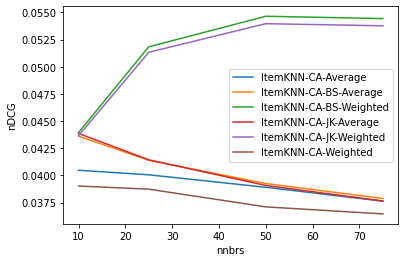

In [336]:
### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
mf_scores = ndcg.groupby(['name', 'nnbrs'])['ndcg'].mean().reset_index()
#pop_score = ndcg[ndcg['AlgoClass'] == 'Popular']['ndcg'].mean()
#plt.axhline(pop_score, color='grey', linestyle='--', label='Popular')
for algo, data in mf_scores.groupby('name'):
    plt.plot(data['nnbrs'], data['ndcg'], label=algo)
plt.legend()
plt.xlabel('nnbrs')
plt.ylabel('nDCG')

Text(0, 0.5, 'Precision')

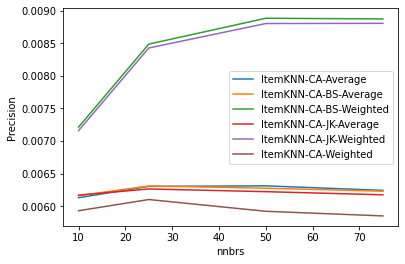

In [337]:
### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
mf_scores = ndcg.groupby(['name', 'nnbrs'])['precision'].mean().reset_index()
#pop_score = ndcg[ndcg['AlgoClass'] == 'Popular']['ndcg'].mean()
#plt.axhline(pop_score, color='grey', linestyle='--', label='Popular')
for algo, data in mf_scores.groupby('name'):
    plt.plot(data['nnbrs'], data['precision'], label=algo)
plt.legend()
plt.xlabel('nnbrs')
plt.ylabel('Precision')

In [214]:
#truth # user, item, rating, timestamp - 3355
#preds # RunId, user, item rating, prediction

### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
pred_acc = preds.join(runs[['name', 'nnbrs']], on = 'RunId')
pred_acc.head()


#from lenskit.metrics.predict import rmse
#rmse(preds['prediction'], preds['rating'])

,RunId,user,item,rating,prediction,name,nnbrs
0,1,3,1641,2.0,4.148490,ItemKNN-CA-BS-Weighted,10.0
1,1,3,2470,4.0,3.719794,ItemKNN-CA-BS-Weighted,10.0
2,1,3,480,4.0,3.593770,ItemKNN-CA-BS-Weighted,10.0
3,1,3,2617,2.0,3.834670,ItemKNN-CA-BS-Weighted,10.0
4,1,3,2355,5.0,3.490995,ItemKNN-CA-BS-Weighted,10.0


In [215]:
#pred_acc.loc[pred_acc['prediction'] > 5,'prediction'] = 5
#pred_acc.loc[pred_acc['prediction'] < 1,'prediction'] = 1

pred_acc['se'] = (pred_acc['rating'] - pred_acc['prediction'])**2


#pred_acc.groupby(['AlgoClass', 'nnbrs'])['rating','prediction'])


#ndcg.fillna(0).groupby(['AlgoClass', 'nnbrs'])['ndcg','precision'].mean()

[   INFO] numexpr.utils NumExpr defaulting to 4 threads.


In [216]:
import numpy as np
#from np import sqrt
np.sqrt(pred_acc.groupby(['name', 'nnbrs'])['se'].mean())

name                    nnbrs
ItemKNN-CA-BS-Weighted  10.0     0.873556
                        25.0     0.869970
                        75.0     0.877593
Name: se, dtype: float64

Text(0, 0.5, 'RMSE')

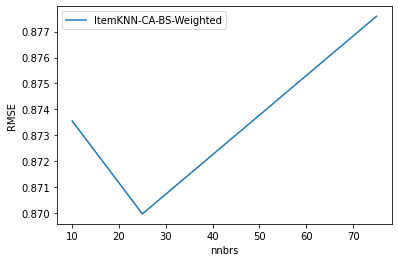

In [217]:
### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
knn_pred_scores = np.sqrt(pred_acc.groupby(['name', 'nnbrs'])['se'].mean()).reset_index()
knn_pred_scores.head()
#pop_score = ndcg[ndcg['AlgoClass'] == 'Popular']['ndcg'].mean()
#plt.axhline(pop_score, color='grey', linestyle='--', label='Popular')
for algo, data in knn_pred_scores.groupby('name'):
    plt.plot(data['nnbrs'], data['se'], label=algo)
plt.legend()
plt.xlabel('nnbrs')
plt.ylabel('RMSE')